# Immune disease classifier

## Research Question:
Is it possible to build a model for multi-class classification of immune system malignancies and diseases? By observing single-cell transcriptomic states, can we predict the disease from a set of 12:

    B-cell acute lymphoblastic leukemia
    B-cell non-Hodgkin lymphoma
    Crohn's disease
    Cholangitis
    Common variable immunodeficiency
    Follicular lymphoma
    Localized scleroderma
    Multiple sclerosis
    Plasma cell myeloma
    Premalignant hematological system disease
    Systemic lupus erythematosus
    Type 1 diabetes mellitus
## Data Source:
CellxGene Census – a collection of single-cell transcriptomics data from multiple patients.
  
    https://chanzuckerberg.github.io/cellxgene-census/

## Techniques Used in Analysis:
Each cell (entry) contains 50,000 features, and differential gene expression was performed to down-select only the most important features.
Cell types were balanced using synthetic cells generated through Poisson noise applied to real cells.
Multiple models were trained for multi-class prediction and tested on unseen patients to ensure high precision and recall.

## Expected Results:
A classifier capable of distinguishing between 12 immune system diseases, reliably diagnosing each patient with precision and high recall.

## Bussiness objectives:
This research aims to explore a novel data modality—single-cell transcriptomics—for diagnostics, which has not yet been widely applied in this domain. The development of a universal model capable of distinguishing between immune diseases using uniform molecular input, without relying on phenotypic data, could significantly enhance decision-making in medicine and supplement the $15B immune disease diagnostics market.

Currently, diagnostic tools predominantly rely on phenotypic markers, which can make it difficult to differentiate between diseases with overlapping clinical presentations. However, these diseases are distinguishable at the molecular level. This research seeks to harness molecular data to create a universal model for diagnosing immune diseases, even in the absence of additional phenotypic information.

In [110]:
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay,confusion_matrix, roc_curve, roc_auc_score, multilabel_confusion_matrix, classification_report
from sklearn.metrics import auc as skl_auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.exceptions import ConvergenceWarning
set_config("figure")

# Suppress only ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Suppress all warnings globally
warnings.filterwarnings("ignore")


## Read the data

Data is stored in a special AnnData object that allows to hold multiple matrices of data as well as variables and obseravtion lists together, it is specifically desinged for handingling big data problems in single cell omics.

In [175]:
#Data is lodaed in a special object called AnnData
adata = sc.read_h5ad('data/disease_dataset_balanced.h5ad')

## Feature understanding

In [176]:
# Description of data
adata

AnnData object with n_obs × n_vars = 1647995 × 4328
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'is_real_cell'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'geneformer', 'scgpt', 'scvi'

In [177]:
# I am using scanpy's method to normalize data to number of counts per gene per 10,000 reads (read is a unit of transcription depth), since each cell can have different depth we are normalizing each gene depth for each cell by the total depth of the cell divided by 10,000
sc.pp.normalize_total(adata, target_sum=10000)
# To further regularize data I have log1p transformed the dataset
sc.pp.log1p(adata)

In [178]:
# Count how many cells are real and how many are synthetic
adata.obs['is_real_cell'].value_counts()

is_real_cell
fake         1134392
real          442540
augmented      71063
Name: count, dtype: int64

#### Note:
    There are 1,134,392 fake cells and 442,540 real cells and 71,063 cells that are augmented
    Fake cells are cells added as decoys - they have incorrect disease labels, and exist to confuse model from learning specific cell types
    Real cells are actual real cells
    Augmented cells are real cells with added poisson noise used to help cell type populations that are below 30 cells.

#### I have trained on datasets including and excluding fake cells - fake cells balance dataset so that model can't learn which cell type is disease associated which is beneficial from learning about specific disease gene networks but it makes the learning process much more difficult. 

In [179]:
#Reset index
adata.obs.reset_index(drop=True, inplace=True)

In [180]:
# Count how many real and augmented cells are per disease
adata.obs[(adata.obs['is_real_cell']=='real') | (adata.obs['is_real_cell']=='augmented')]['disease'].value_counts()

disease
Crohn disease                                131618
B-cell acute lymphoblastic leukemia           76144
primary sclerosing cholangitis                60945
systemic lupus erythematosus                  52157
common variable immunodeficiency              42499
follicular lymphoma                           36960
primary biliary cholangitis                   29163
B-cell non-Hodgkin lymphoma                   25964
premalignant hematological system disease     25661
type 1 diabetes mellitus                      12049
plasma cell myeloma                           10437
multiple sclerosis                             9020
localized scleroderma                           986
Name: count, dtype: int64

In [181]:
# Count how many real, augmented and fake cells are there per disease
adata.obs['disease'].value_counts()

disease
Crohn disease                                187321
B-cell acute lymphoblastic leukemia          156423
systemic lupus erythematosus                 145282
primary sclerosing cholangitis               140940
follicular lymphoma                          126936
premalignant hematological system disease    121699
common variable immunodeficiency             120362
B-cell non-Hodgkin lymphoma                  114093
type 1 diabetes mellitus                     109637
primary biliary cholangitis                  109158
plasma cell myeloma                          107908
multiple sclerosis                           104125
localized scleroderma                        104111
Name: count, dtype: int64

## Features engineering

#### Note: I have merge both cholangitis-related diseases into single label
    Primary sclerosing cholangitis and Primary biliary cholangitis are very simillar diseases and I have made decision to not differentiate between them.

In [182]:
# Add category for Cholongitis
adata.obs['disease'] = adata.obs['disease'].cat.add_categories('cholangitis')
# Reassign primary sclerosing cholangitis to Cholongitis
adata.obs.loc[adata.obs['disease'] == 'primary sclerosing cholangitis', 'disease'] = 'cholangitis'
# Reassign primary biliary cholangitis to Cholongitis
adata.obs.loc[adata.obs['disease'] == 'primary biliary cholangitis', 'disease'] = 'cholangitis'
# Remove primary biliary cholangitis and primary sclerosing cholangitis from categories
adata.obs['disease'] = adata.obs['disease'].cat.remove_categories(['primary sclerosing cholangitis', 'primary biliary cholangitis'])

In [183]:
#Reset index
adata.obs.reset_index(drop=True, inplace=True)

In [184]:
# Count how many real and augmented cells are per disease
adata.obs[(adata.obs['is_real_cell']=='real') | (adata.obs['is_real_cell']=='augmented')]['disease'].value_counts()

disease
Crohn disease                                131618
cholangitis                                   90108
B-cell acute lymphoblastic leukemia           76144
systemic lupus erythematosus                  52157
common variable immunodeficiency              42499
follicular lymphoma                           36960
B-cell non-Hodgkin lymphoma                   25964
premalignant hematological system disease     25661
type 1 diabetes mellitus                      12049
plasma cell myeloma                           10437
multiple sclerosis                             9020
localized scleroderma                           986
Name: count, dtype: int64

In [185]:
# Count how many real, augmented and fake cells are there per disease
adata.obs['disease'].value_counts()

disease
cholangitis                                  250098
Crohn disease                                187321
B-cell acute lymphoblastic leukemia          156423
systemic lupus erythematosus                 145282
follicular lymphoma                          126936
premalignant hematological system disease    121699
common variable immunodeficiency             120362
B-cell non-Hodgkin lymphoma                  114093
type 1 diabetes mellitus                     109637
plasma cell myeloma                          107908
multiple sclerosis                           104125
localized scleroderma                        104111
Name: count, dtype: int64

#### Note:
    In the real dataset there are very few donors for some diseases, which makes it hard to split data, as the split need to go along donor_id, the dataset with fake cells was also augmented to have more donor_ids by splitting original donors and randomly sampling cells from them and backfilling them with augmented and fake cells.


In [186]:
# Count how many donors are there per disease only for real and augmented cells
adata.obs[(adata.obs['is_real_cell'] == 'real') | (adata.obs['is_real_cell'] == 'augmented')].groupby('disease')['donor_id'].nunique()

disease
B-cell acute lymphoblastic leukemia           18
B-cell non-Hodgkin lymphoma                   17
Crohn disease                                 53
cholangitis                                   13
common variable immunodeficiency              11
follicular lymphoma                           20
localized scleroderma                          6
multiple sclerosis                             4
plasma cell myeloma                           55
premalignant hematological system disease     17
systemic lupus erythematosus                 162
type 1 diabetes mellitus                       5
Name: donor_id, dtype: int64

In [187]:
# Count how many donors are there per disease for dataset augmented with fake cells
adata.obs.groupby('disease')['donor_id'].nunique()

disease
B-cell acute lymphoblastic leukemia          2267
B-cell non-Hodgkin lymphoma                  2677
Crohn disease                                2495
cholangitis                                  3109
common variable immunodeficiency             2202
follicular lymphoma                          2680
localized scleroderma                        2696
multiple sclerosis                           2765
plasma cell myeloma                          2857
premalignant hematological system disease    2736
systemic lupus erythematosus                 2788
type 1 diabetes mellitus                     2800
Name: donor_id, dtype: int64

## Train/test split data

In [188]:
# One hot encode dataset
disease_one_hot_df = pd.get_dummies(adata.obs['disease'])
dict(enumerate(disease_one_hot_df.columns))

{0: 'B-cell acute lymphoblastic leukemia',
 1: 'B-cell non-Hodgkin lymphoma',
 2: 'Crohn disease',
 3: 'cholangitis',
 4: 'common variable immunodeficiency',
 5: 'follicular lymphoma',
 6: 'localized scleroderma',
 7: 'multiple sclerosis',
 8: 'plasma cell myeloma',
 9: 'premalignant hematological system disease',
 10: 'systemic lupus erythematosus',
 11: 'type 1 diabetes mellitus'}

##### Test set must have unseen donors and must be real cells

In [209]:
#How many cells per disease
n_val_samples_per_class = 500
### Split test/train donor ids
val_donor_ids = []

for disease in disease_one_hot_df.columns:
    # Get unique donor IDs for the current disease
    donors = adata.obs[
        (adata.obs['disease'] == disease) & 
        (adata.obs['is_real_cell'] == 'real')
    ]['donor_id'].unique()
    
    # Determine the number of validation donors (40% of total donors for the disease)
    n_val_donors = max(2, int(0.4 * len(donors)))  # Ensure at least 2 donors
    
    # Randomly sample donor IDs for validation
    sampled_val_donors = np.random.choice(donors, n_val_donors, replace=False)
    
    # Add sampled donor IDs to the validation set
    val_donor_ids.extend(sampled_val_donors)

# List of donor_ids
donor_ids = adata.obs['donor_id'].unique()
#Substratct val_donor_ids from donor_ids
train_donor_ids = np.setdiff1d(donor_ids, val_donor_ids)

# Create a mask for test set
val_donor_mask = adata.obs['donor_id'].isin(val_donor_ids)
# Create a mask for train set
train_donor_mask = adata.obs['donor_id'].isin(train_donor_ids)

#Select random sample og 500 cells per disease
val_indices = []
for disease in disease_one_hot_df.columns:
    disease_val_indices = disease_one_hot_df.index[(adata.obs['disease'] == disease) & (adata.obs['is_real_cell']=='real') & val_donor_mask].tolist()
    
    if len(disease_val_indices) >= n_val_samples_per_class:
        sampled_val_indices = np.random.choice(disease_val_indices, n_val_samples_per_class, replace=False)
        val_indices.extend(sampled_val_indices)
    else:
        raise ValueError(f"Not enough samples for class '{disease}' to have {n_val_samples_per_class} validation samples.")

train_indices = adata.obs.index[train_donor_mask]

In [210]:
#Create train set
train_adata = adata[train_indices]
#Create test set
val_adata = adata[val_indices]

In [211]:
#Count number of donors in test set
val_adata.obs.groupby('disease')['donor_id'].nunique()

disease
B-cell acute lymphoblastic leukemia           7
B-cell non-Hodgkin lymphoma                   6
Crohn disease                                21
cholangitis                                   5
common variable immunodeficiency              4
follicular lymphoma                           8
localized scleroderma                         2
multiple sclerosis                            2
plasma cell myeloma                          22
premalignant hematological system disease     6
systemic lupus erythematosus                 64
type 1 diabetes mellitus                      2
Name: donor_id, dtype: int64

In [212]:
#Count how many real donors are in train set
train_adata.obs[(adata.obs['is_real_cell'] == 'real') | (adata.obs['is_real_cell'] == 'augmented')].groupby('disease')['donor_id'].nunique().sort_values(ascending=False)

disease
systemic lupus erythematosus                 98
plasma cell myeloma                          33
Crohn disease                                32
follicular lymphoma                          12
B-cell acute lymphoblastic leukemia          11
B-cell non-Hodgkin lymphoma                  11
premalignant hematological system disease    11
cholangitis                                   8
common variable immunodeficiency              7
localized scleroderma                         4
type 1 diabetes mellitus                      3
multiple sclerosis                            2
Name: donor_id, dtype: int64

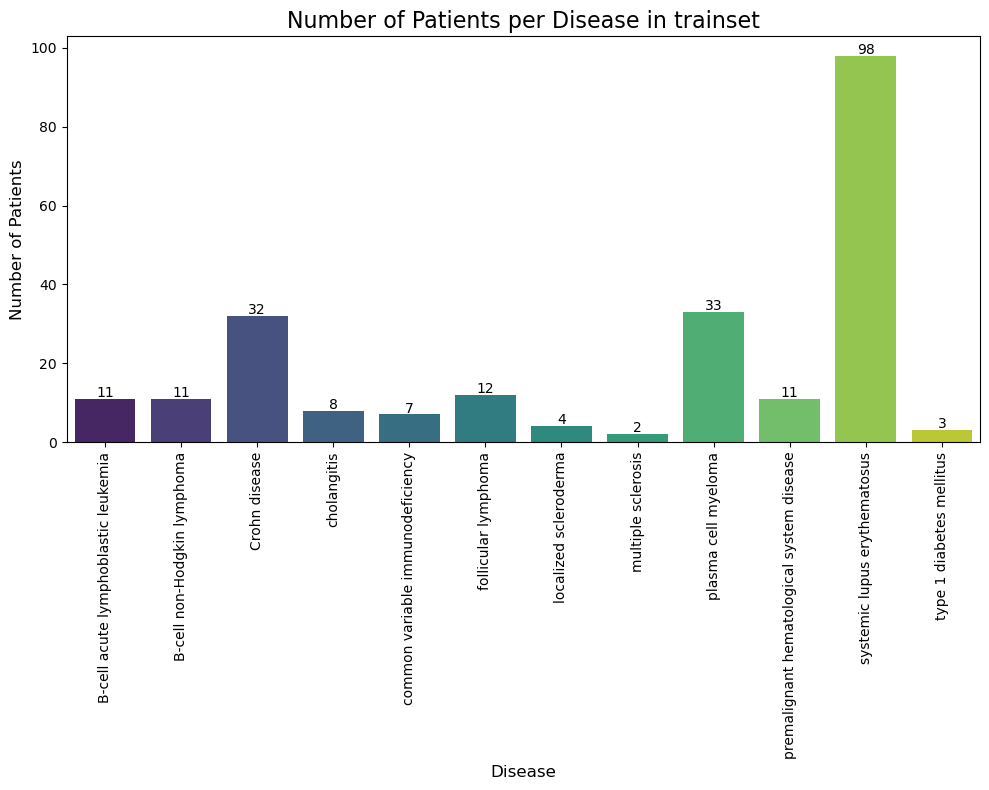

In [213]:
# Number of Patients per Disease in trainset
counts = (
    train_adata.obs[
        (train_adata.obs['is_real_cell'] == 'real') | (train_adata.obs['is_real_cell'] == 'augmented')
    ]
    .groupby('disease')['donor_id']
    .nunique()
)

# Create the barplot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=counts.index, y=counts.values, palette="viridis")

# Add labels above the bars
for i, value in enumerate(counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', fontsize=10)

# Add labels and title
plt.xlabel("Disease", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.title("Number of Patients per Disease in trainset", fontsize=16)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [214]:
#Count number of real cells in test set
val_adata.obs['disease'].value_counts()

disease
B-cell acute lymphoblastic leukemia          500
B-cell non-Hodgkin lymphoma                  500
Crohn disease                                500
cholangitis                                  500
common variable immunodeficiency             500
follicular lymphoma                          500
localized scleroderma                        500
multiple sclerosis                           500
plasma cell myeloma                          500
premalignant hematological system disease    500
systemic lupus erythematosus                 500
type 1 diabetes mellitus                     500
Name: count, dtype: int64

In [215]:
#Count number of cells in train set
train_adata.obs['disease'].value_counts()

disease
cholangitis                                  213350
Crohn disease                                132755
systemic lupus erythematosus                 124870
B-cell acute lymphoblastic leukemia          123707
premalignant hematological system disease    114158
follicular lymphoma                          110412
B-cell non-Hodgkin lymphoma                  105937
type 1 diabetes mellitus                     105029
plasma cell myeloma                          103605
localized scleroderma                        103546
common variable immunodeficiency             100767
multiple sclerosis                            98474
Name: count, dtype: int64

In [216]:
# Count how many real and augmented cells are per disease in train set
train_adata.obs[(adata.obs['is_real_cell']=='real') | (adata.obs['is_real_cell']=='augmented')].groupby('disease').size().sort_values(ascending=False)

disease
Crohn disease                                77052
cholangitis                                  53360
B-cell acute lymphoblastic leukemia          43428
systemic lupus erythematosus                 31745
common variable immunodeficiency             22904
follicular lymphoma                          20436
premalignant hematological system disease    18120
B-cell non-Hodgkin lymphoma                  17808
type 1 diabetes mellitus                      7441
plasma cell myeloma                           6134
multiple sclerosis                            3369
localized scleroderma                          421
dtype: int64

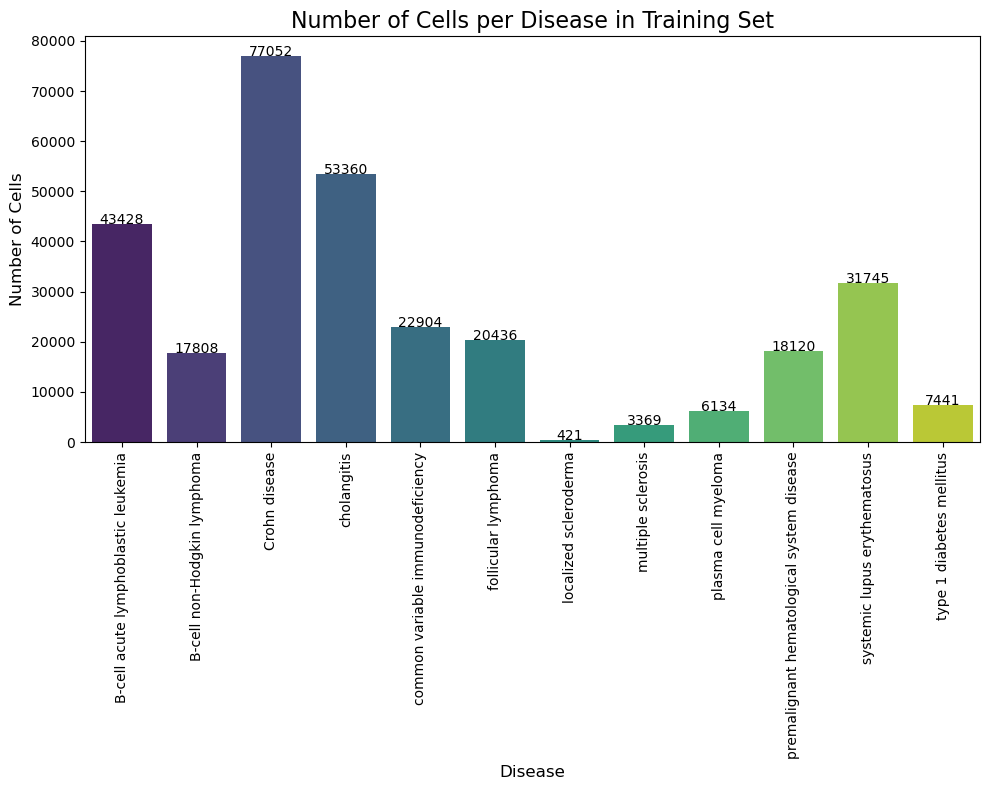

In [217]:
# Prepare the data
counts = (
    train_adata.obs[
        (train_adata.obs['is_real_cell'] == 'real') | (train_adata.obs['is_real_cell'] == 'augmented')
    ]
    .groupby('disease')
    .size()
)

# Create the barplot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=counts.index, y=counts.values, palette="viridis")

# Add labels above the bars
for i, value in enumerate(counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', fontsize=10)

# Add labels and title
plt.xlabel("Disease", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.title("Number of Cells per Disease in Training Set", fontsize=16)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [218]:
#Create training and test set, downsample the data to float16 to save memory
X_train = train_adata.X.toarray().astype('float16')
X_test = val_adata.X.toarray().astype('float16')
y_train = train_adata.obs['disease']
y_test = val_adata.obs['disease']

## Note:
    To lower memory needs I have created smaller datasets

In [220]:
#Create small set for training 
X_train95, X_train05, y_train95, y_train05 = train_test_split(X_train, y_train, test_size=0.05, random_state=42)
X_train95 = None
y_train95 = None

In [221]:
#Create small set for training 
X_train99, X_train01, y_train99, y_train01 = train_test_split(X_train, y_train, test_size=0.01, random_state=42)
X_train99 = None
y_train99 = None

In [222]:
#Create training and test set for real and augmented cells only,
is_real_train= np.where((train_adata.obs['is_real_cell']=='real') | (train_adata.obs['is_real_cell']=='augmented'), 1, 0)
X_train_real = X_train[is_real_train==1]
y_train_real = y_train[is_real_train==1]
X_train_real90, X_train_real10, y_train_real90, y_train_real10 = train_test_split(X_train_real, y_train_real, test_size=0.20, random_state=42)
X_train_real90 = None
y_train_real90 = None

In [223]:
#Free RAM from variables no longer used
X_train = None
y_train = None
adata = None
train_adata = None
val_adata = None
import gc
gc.collect()

17871

# Analysis: Baseline model

## Dummy classifier fake cells

,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
Dummy classifier - cell bias,0.151,0.083,0.007,0.083,0.013,0.5,0.0,71831


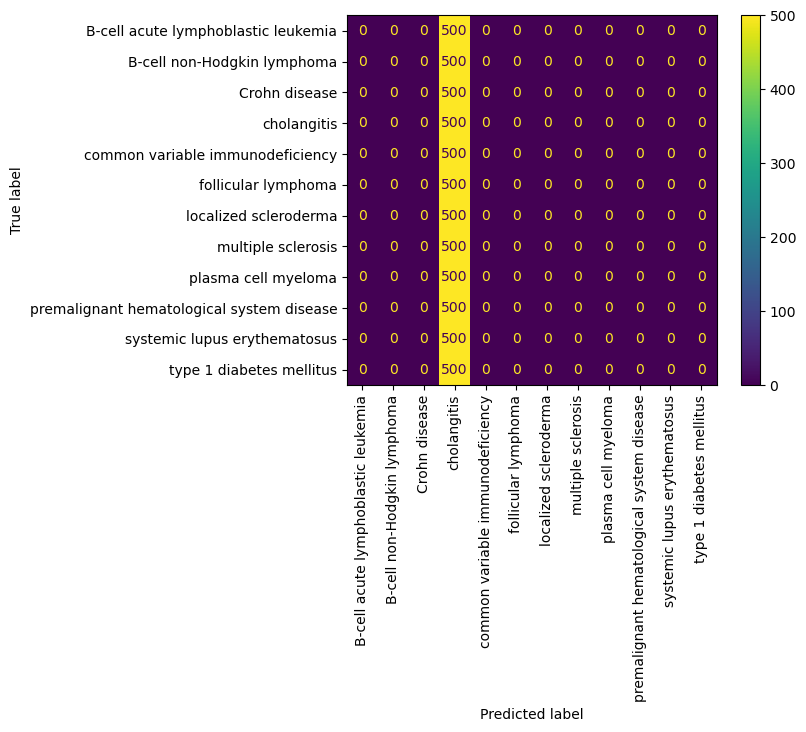

In [224]:
start_time = time.time()
pipe = DummyClassifier().fit(X_train05,y_train05)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = pipe.predict(X_test)
acc_train = pipe.score(X_train05,y_train05)
acc_test = pipe.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = pipe.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

#Save results in the dataframe 
dummy1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train05)]
                         },index=['Dummy classifier  - cell bias'])
dummy1_report_df = pd.DataFrame(report)
dummy1_df

# Models without cell type bias

## KNN Classifier without cell type bias

Best Parameters:  {'knn__n_neighbors': 15}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
KNN classifier - cell bias,0.278,0.291,0.336,0.291,0.252,0.656,285.9,71831


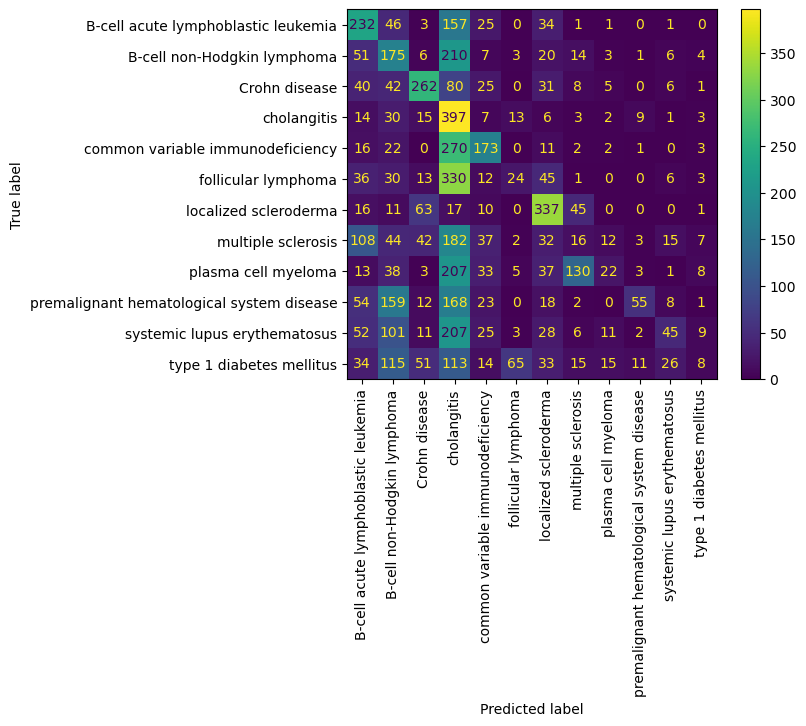

In [226]:
#Set up pipeline
pipe = Pipeline([('knn',KNeighborsClassifier(n_jobs=-1))])

# parameters to search
params_knn = {'knn__n_neighbors':[15,25,50],
#              'knn__p' :[1, 2]
#              'knn__weights' : ('uniform', 'distance'),
#              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#              'knn__leaf_size': [10, 20, 30, 40, 50],
#              'knn__metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev']
}            


start_time = time.time()
grid = RandomizedSearchCV(pipe,
                          param_distributions=params_knn,
                          scoring='f1_weighted'
                          ,refit='recall',
                          n_jobs=3,
                          pre_dispatch="2*n_jobs",
                          n_iter=3,
                          cv=3).fit(X_train05,y_train05)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train05,y_train05)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
knn1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train05)]
                       },index=['KNN classifier - cell bias'])
knn1_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
knn1_df

## Logistic Regression without cell type bias

Best Parameters:  {'logreg__fit_intercept': True, 'logreg__C': 9.999999999999999e-05}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
LogReg classifier - cell bias,0.35,0.809,0.855,0.809,0.786,0.959,696.8,71831


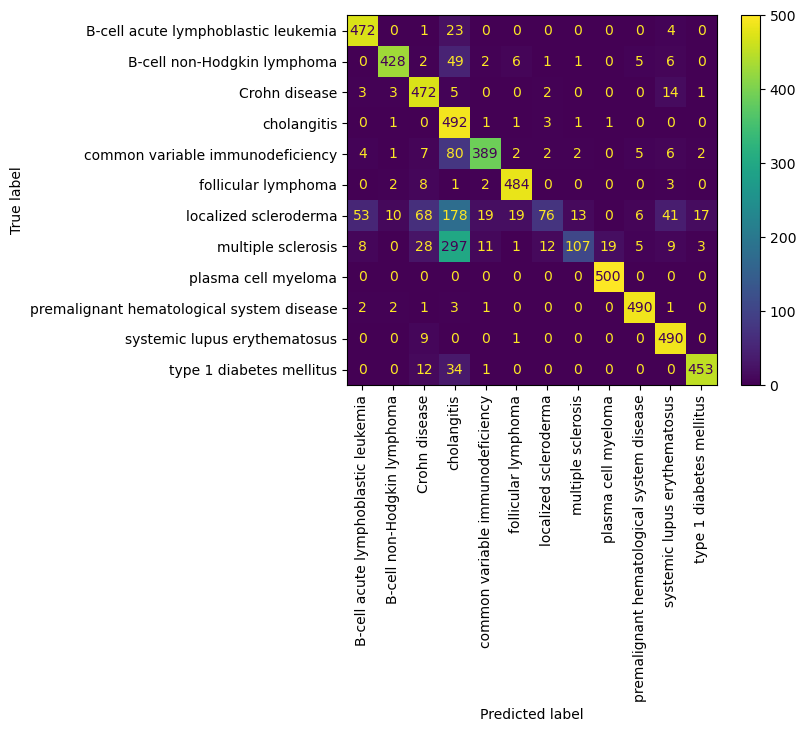

In [225]:
gc.collect()
#Define the Logistic regression pipeline 
logreg_pipe = Pipeline([('scaler',StandardScaler()),('logreg',LogisticRegression(n_jobs=-1,max_iter=4000))])
# Define hyperparameters to search
param_logreg = {'logreg__C': np.logspace(-4, 2, 3),
#                'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#                'logreg__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cholesky'],  # 'newton-cg' and 'sag' only support l2
#                'logreg__class_weight': [None, 'balanced'],
#                'logreg__l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
#                'logreg__tol': [1e-4, 1e-3, 1e-2, 1e-1],
                'logreg__fit_intercept': [True, False],
}
start_time = time.time()
grid = RandomizedSearchCV(logreg_pipe,
                          param_distributions=param_logreg,
                          scoring='f1_weighted',
                          n_jobs=3,
                          refit='recall',
                          pre_dispatch="2*n_jobs",
                          n_iter=2,
                          cv=3).fit(X_train05,y_train05)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train05,y_train05)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
logreg1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train05)]
                          },index=['LogReg classifier - cell bias'])
logreg1_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
logreg1_df

## Decision Tree Classifier without cell type bias

Best Parameters:  {'tree__max_depth': 96}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
DecisionTree classifier - cell bias,0.971,0.468,0.443,0.468,0.447,0.714,254.0,36623


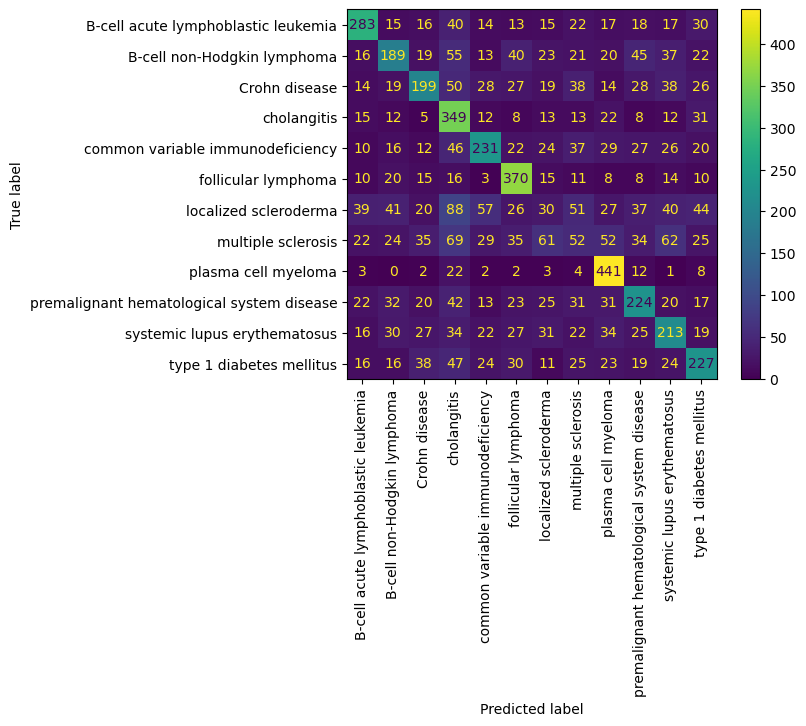

In [144]:
gc.collect()
#Define the Decision tree pipeline of DecisionTreeClassifier
dtree_pipe = Pipeline([('tree', DecisionTreeClassifier())])

#Hyperparameters to search
params = {
    'tree__max_depth': [12,48,96],  # Try a range of depths or leave as None for no limit
#    'tree__min_samples_split': [0.0001, 0.001, 0.01, 0.1],  # Minimum number of samples required to split a node
#    'tree__criterion': ['gini', 'entropy'],  # Metrics to measure the quality of a split
#    'tree__min_samples_leaf': [1,2,4,8,16],  # Minimum number of samples required at a leaf node
}
#Perform RandomizedSearchCV on dtree_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(dtree_pipe,
                          param_distributions=params,
                          scoring='f1_weighted',
                          n_jobs=3,
                          refit='recall',
                          pre_dispatch="2*n_jobs",
                          n_iter=3,
                          cv=3).fit(X_train05,y_train05)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train05,y_train05)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
dtree1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train05)]
                         },index=['DecisionTree classifier - cell bias'])
dtree1_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
dtree1_df

## Random Forest Classifier without cell type bias

Best Parameters:  {'forest__n_estimators': 400, 'forest__criterion': 'gini'}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
RandomForest classifier - cell bias,0.998,0.756,0.892,0.756,0.766,0.978,578.1,36177


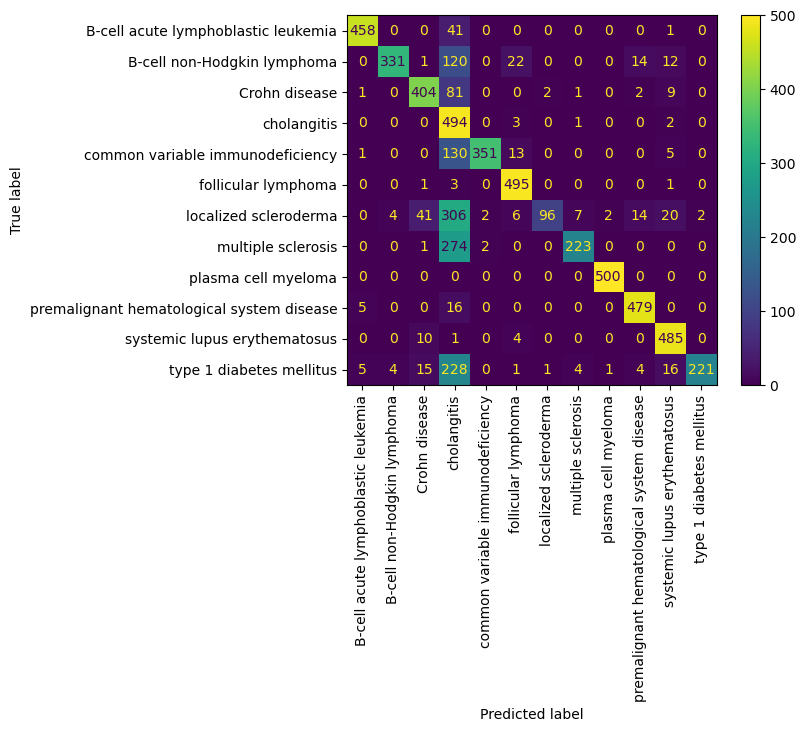

In [35]:
gc.collect()
# Define the Random Forest pipeline
rf_pipe = Pipeline([('forest', RandomForestClassifier(random_state=42))])

# Hyperparameters for Random Forest to search
params = {
    'forest__n_estimators': [100,400],        
#    'forest__max_depth': [None, 10],          
#    'forest__min_samples_split': [20],      
    'forest__criterion': ['gini']             
}

# Perform RandomizedSearchCV on rf_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(rf_pipe,
                          param_distributions=params, 
                          scoring='f1_weighted',
                          n_jobs=3,
                          refit='recall',
                          pre_dispatch="2*n_jobs",
                          n_iter=2,
                          cv=3,
                          random_state=42).fit(X_train05,y_train05)
end_time = time.time()

# How much time did it take
execution_time = end_time - start_time

# Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train05,y_train05)
acc_test = grid.best_estimator_.score(X_test, y_test)
report = classification_report(y_test, preds, output_dict=True)

# Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test, preds, labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels).plot()
plt.xticks(rotation=90)

# Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

# Save results in the dataframe
rf1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train05)]
                     }, index=['RandomForest classifier - cell bias'])

rf_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
rf1_df

## AdaBoost Classifier without cell type bias

/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters:  {'ada__n_estimators': 200, 'ada__estimator': DecisionTreeClassifier(max_depth=1)}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
AdaBoost classifier - cell bias,0.271,0.546,0.633,0.546,0.539,0.758,1190.1,36177


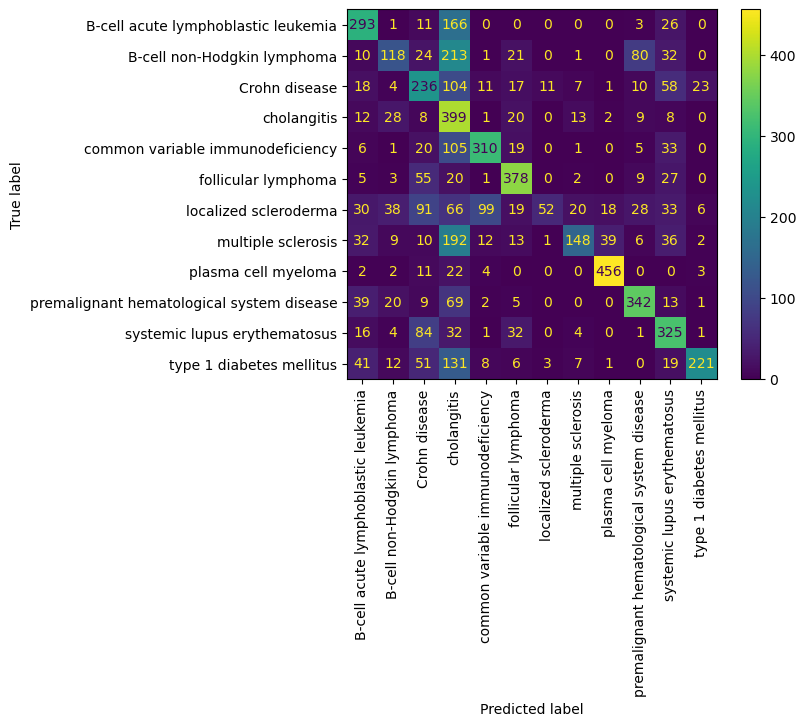

In [36]:
gc.collect()
# Define the AdaBoost pipeline
ada_pipe = Pipeline([('ada', AdaBoostClassifier(random_state=42, algorithm='SAMME.R'))])

# Hyperparameters for AdaBoost to search
params = {
    'ada__n_estimators': [200],      
#    'ada__learning_rate': [0.1, 1],
    'ada__estimator': [DecisionTreeClassifier(max_depth=d) for d in [1]]
}

# Perform RandomizedSearchCV on ada_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(
    ada_pipe,
    param_distributions=params,
    scoring='f1_weighted',
    n_jobs=3,
    refit='recall',
    pre_dispatch="1*n_jobs",
    n_iter=1,
    cv=3,
    random_state=42
).fit(X_train05, y_train05)
end_time = time.time()

# How much time did it take
execution_time = end_time - start_time

# Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train05, y_train05)
acc_test = grid.best_estimator_.score(X_test, y_test)
report = classification_report(y_test, preds, output_dict=True)

# Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test, preds, labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels).plot()
plt.xticks(rotation=90)

# Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

# Save results in the dataframe
ada1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train05)]
                      }, index=['AdaBoost classifier - cell bias'])

ada_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
ada1_df

## Gradient Boosting Classifier without cell type bias

Best Parameters:  {'gb__n_estimators': 200}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
GradientBoosting classifier - cell bias,0.67,0.638,0.64,0.638,0.618,0.905,12125.4,14471


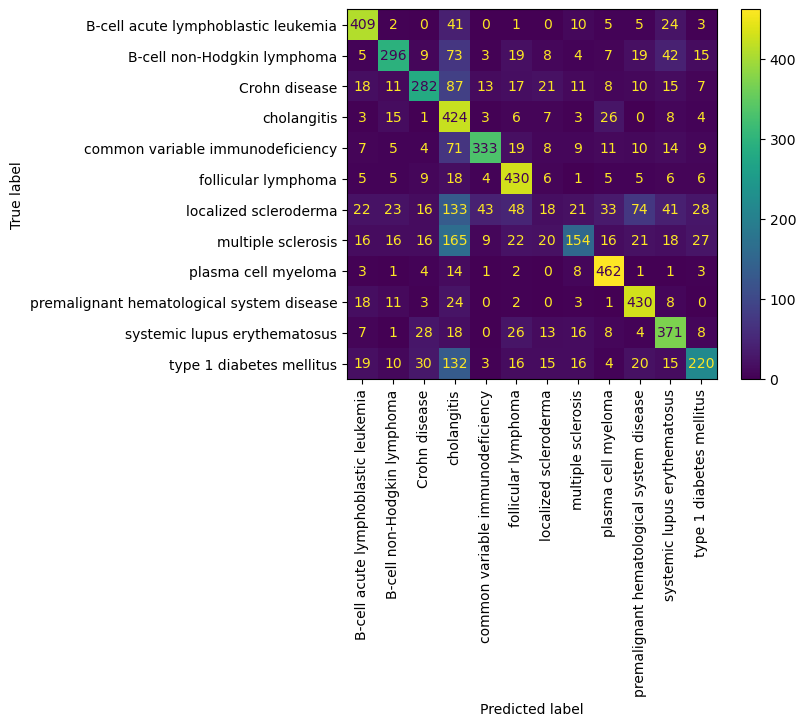

In [37]:
gc.collect()
# Define the Gradient Boosting pipeline
gb_pipe = Pipeline([('gb', GradientBoostingClassifier(random_state=42))])

# Hyperparameters for Gradient Boosting to search
params = {
    'gb__n_estimators': [200],      # Similar to AdaBoost: number of trees
#    'gb__learning_rate': [0.1, 1.0],     # Step size shrinkage
#    'gb__max_depth': [1, 3]           # Maximum depth of individual trees
}

# Perform RandomizedSearchCV on gb_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(
    gb_pipe,
    param_distributions=params,
    scoring='f1_weighted',
    n_jobs=3,
    refit='recall',
    pre_dispatch="2*n_jobs",
    n_iter=1,
    cv=3,
    random_state=42
).fit(X_train01, y_train01)
end_time = time.time()

# How much time did it take
execution_time = end_time - start_time

# Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train01, y_train01)
acc_test = grid.best_estimator_.score(X_test, y_test)
report = classification_report(y_test, preds, output_dict=True)

# Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test, preds, labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels).plot()
plt.xticks(rotation=90)

# Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

# Save results in the dataframe
gb1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train01)]
                     }, index=['GradientBoosting classifier - cell bias'])

gb_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
gb1_df

## Linear SVC without cell type bias

/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/

Best Parameters:  {'svc__estimator__C': 0.1}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
Linear SVC - cell bias,0.384,0.309,0.454,0.309,0.264,0.805,16350.1,14471


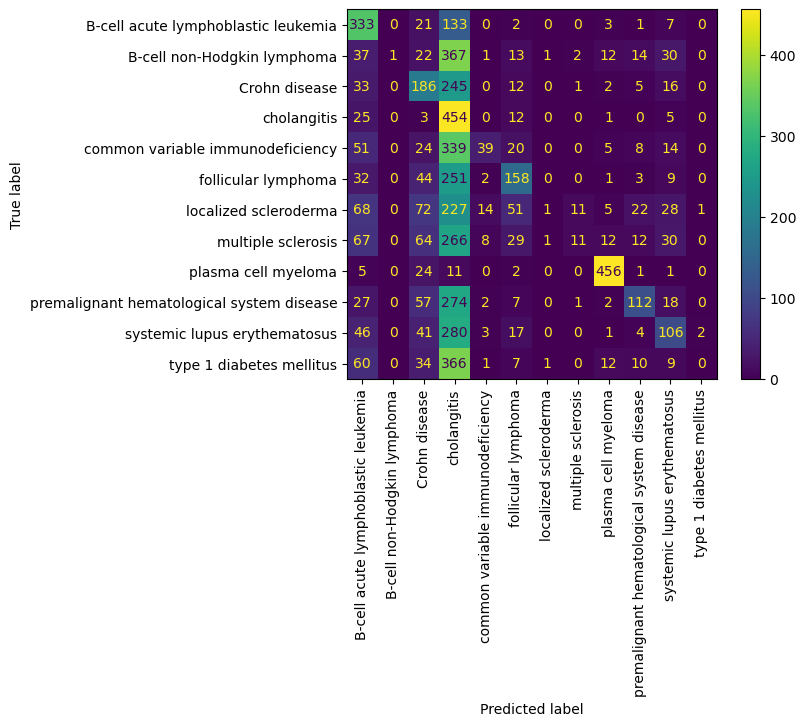

In [42]:
# Suppress ConvergenceWarning
warnings.filterwarnings("ignore")

# Define the pipeline with LinearSVC and calibration
svc_pipe = Pipeline([('scaler',StandardScaler()),
    ('svc', CalibratedClassifierCV(
        estimator=LinearSVC(max_iter=500, class_weight='balanced'),
        method='sigmoid'
    ))
])

# Hyperparameters to search
svc_params = {
    'svc__estimator__C': [0.1, 10]  # Regularization strength
}

#Perform RandomizedSearchCV on svc pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(svc_pipe,
                          param_distributions=svc_params,
                          scoring='f1_weighted',
                          n_jobs=3,
                          refit='recall',
                          pre_dispatch="2*n_jobs",
                          n_iter=2, cv=3).fit(X_train01,y_train01)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train01,y_train01)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
svc1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train01)]
                       },index=['Linear SVC - cell bias'])
svc1_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
svc1_df

# Models with cell type bias

## Dummy classifier real cells

,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
Dummy classifier + cell bias,0.25,0.083,0.007,0.083,0.013,0.5,0.0,66102


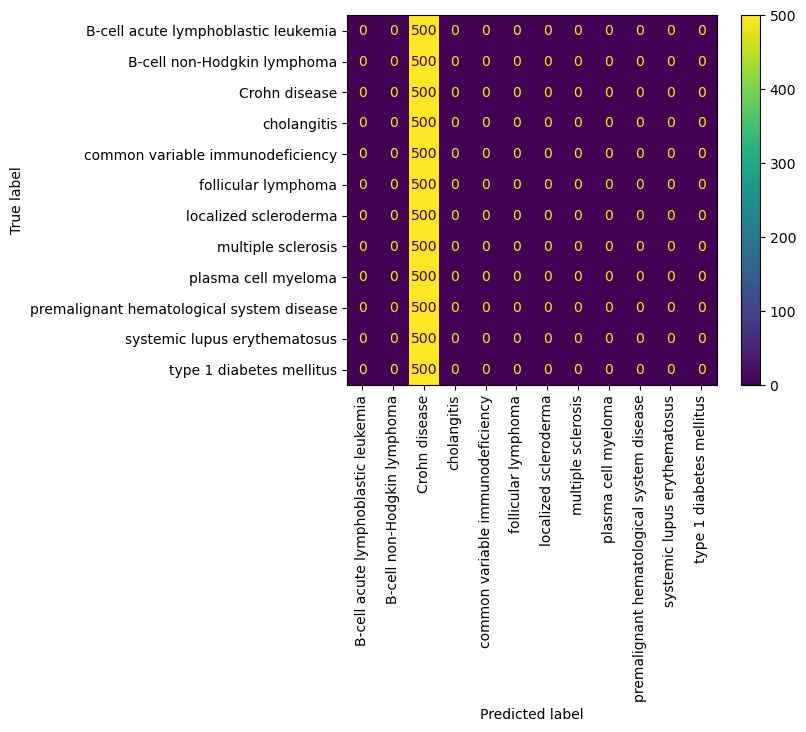

In [145]:
start_time = time.time()
pipe = DummyClassifier().fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = pipe.predict(X_test)
acc_train = pipe.score(X_train_real10,y_train_real10)
acc_test = pipe.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = pipe.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

#Save results in the dataframe 
dummy2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train_real10)]
             },index=['Dummy classifier + cell bias'])
dummy2_report_df = pd.DataFrame(report)
dummy2_df

## KNN - real cells only

Best Parameters:  {'knn__n_neighbors': 3}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
KNN classifier + cell bias,0.783,0.607,0.819,0.607,0.609,0.826,8174.3,281406


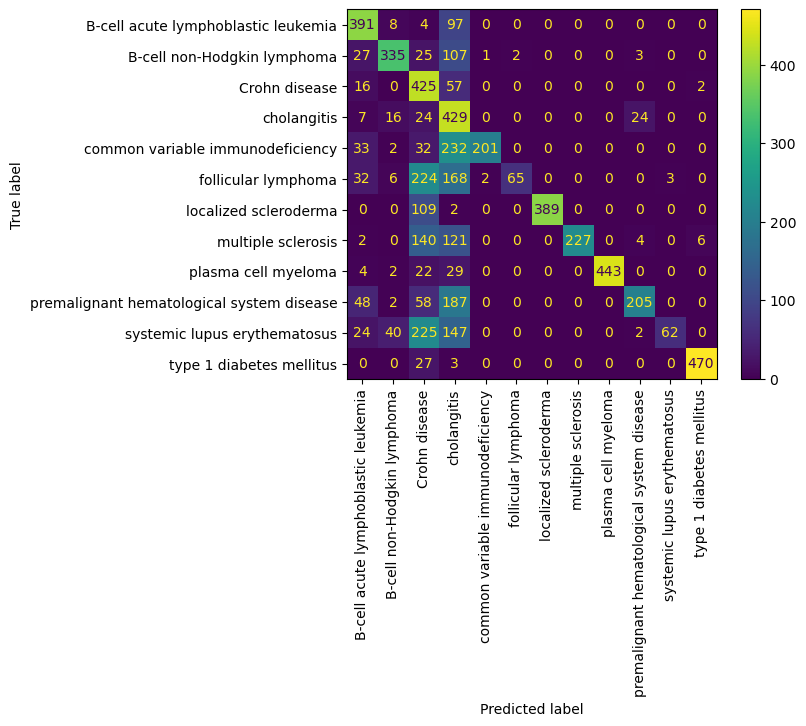

In [44]:
#Set up pipeline
pipe = Pipeline([('knn',KNeighborsClassifier(n_jobs=-1))])

# parameters to search
params_knn = {'knn__n_neighbors':[3,7,13,17,25],
#              'knn__p' :[1, 2]
#              'knn__weights' : ('uniform', 'distance'),
#              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#              'knn__leaf_size': [10, 20, 30, 40, 50],
#              'knn__metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
#              'poly_features__degree': [1,2,3],
#              'poly_features__include_bias': [True, False]
}            


start_time = time.time()
grid = RandomizedSearchCV(pipe,
                          param_distributions=params_knn,
                          scoring='f1_weighted',
                          refit='recall',
                          n_jobs=3,
                          pre_dispatch="2*n_jobs"
                          ,n_iter=5,
                          cv=3).fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
knn2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                        'Test accuracy':[round(acc_test,3)],
                        'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                        'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                        'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                        'Weighted ROC AUC':[round(roc_auc_value,3)],
                        'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train_real10)]
             },index=['KNN classifier + cell bias'])
knn2_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
knn2_df

## Logistic regression - real cells only

Best Parameters:  {'logreg__fit_intercept': True, 'logreg__C': 0.03162277660168379}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
LogReg classifier + cell bias,1.0,0.999,0.999,0.999,0.999,1.0,79.1,66102


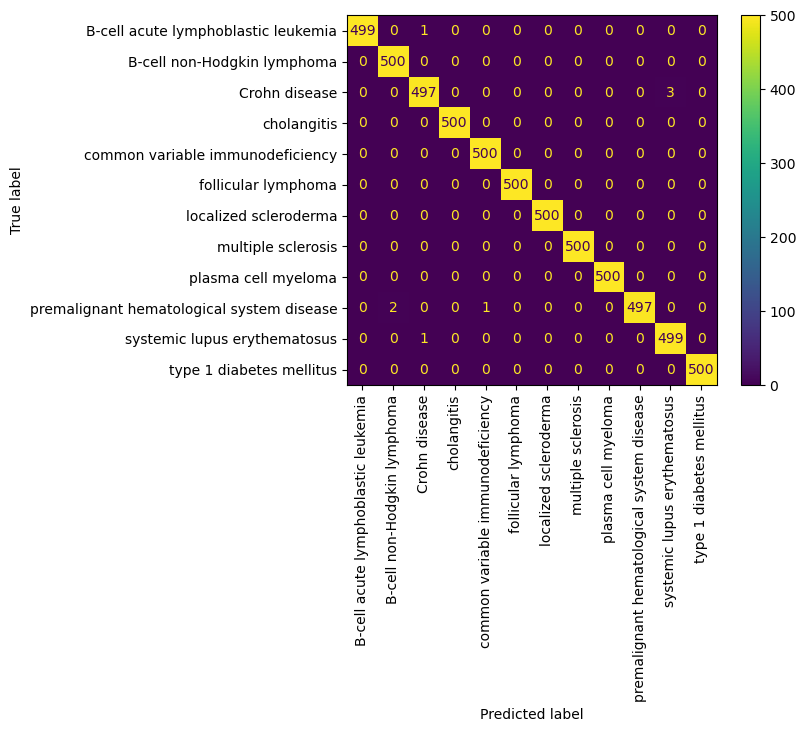

In [146]:
#Define the Logistic regression pipeline 
logreg_pipe = Pipeline([('scaler',StandardScaler()),('logreg',LogisticRegression(n_jobs=-1,max_iter=5000, class_weight='balanced'))])
# Define hyperparameters to search
param_logreg = {'logreg__C': np.logspace(-3, 3, 5),
#                'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#                'logreg__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cholesky'],  # 'newton-cg' and 'sag' only support l2
#                'logreg__class_weight': [None, 'balanced'],
#                'logreg__l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
#                'logreg__tol': [1e-4, 1e-3, 1e-2, 1e-1],
                'logreg__fit_intercept': [True, False]
}
start_time = time.time()
grid = RandomizedSearchCV(logreg_pipe,
                          param_distributions=param_logreg,
                          scoring='f1_weighted',
                          n_jobs=3,
                          refit='recall',
                          pre_dispatch="2*n_jobs"
                          ,n_iter=5,
                          cv=3).fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
logreg2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                           'Test accuracy':[round(acc_test,3)],
                           'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                           'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                           'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                           'Weighted ROC AUC':[round(roc_auc_value,3)],
                           'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train_real10)]
             },index=['LogReg classifier + cell bias'])
logreg2_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
logreg2_df

## Decision Tree with real cells

Best Parameters:  {'tree__min_samples_split': 0.01, 'tree__max_depth': 48}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
DecisionTree classifier + cell bias,0.922,0.784,0.826,0.784,0.776,0.965,3696.9,281406


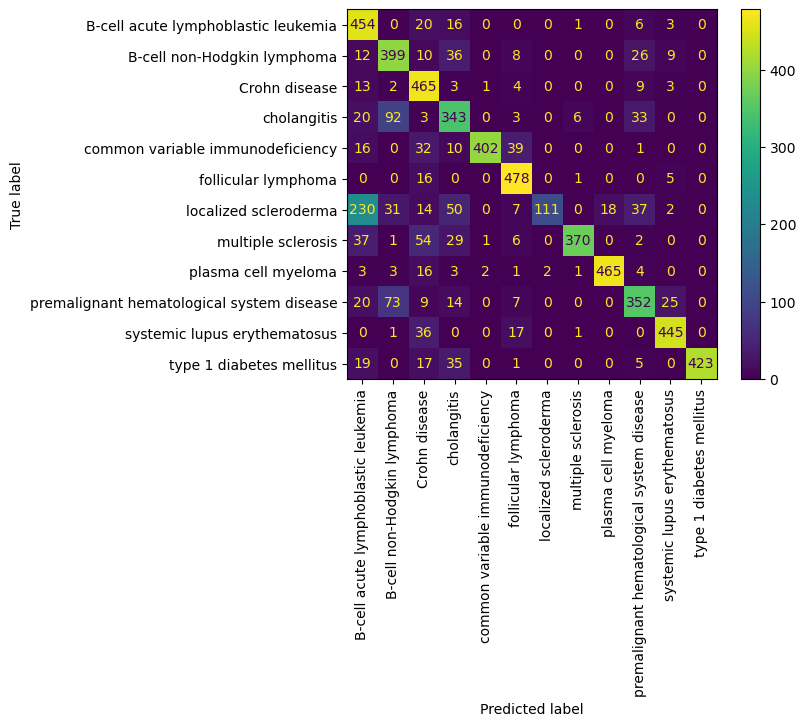

In [46]:
#Define the Decision tree pipeline of DecisionTreeClassifier
dtree_pipe = Pipeline([('tree', DecisionTreeClassifier())])

#Hyperparameters to search
params = {
    'tree__max_depth': [None,3,12,48,96],  # Try a range of depths or leave as None for no limit
    'tree__min_samples_split': [0.0001, 0.01, 0.1],  # Minimum number of samples required to split a node
#    'tree__criterion': ['gini', 'entropy'],  # Metrics to measure the quality of a split
#    'tree__min_samples_leaf': [1,2,4,8,16],  # Minimum number of samples required at a leaf node
}
#Perform RandomizedSearchCV on dtree_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(dtree_pipe, param_distributions=params,  scoring='f1_weighted',n_jobs=3, refit='recall', pre_dispatch="2*n_jobs",n_iter=10, cv=3).fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
dtree2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train_real10)]
             },index=['DecisionTree classifier + cell bias'])
dtree2_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
dtree2_df

## Random Forest Classfier with real cells

Best Parameters:  {'forest__n_estimators': 400, 'forest__min_samples_split': 20, 'forest__criterion': 'gini'}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
RandomForest classifier + cell bias,1.0,0.966,0.969,0.966,0.967,0.999,3330.1,281406


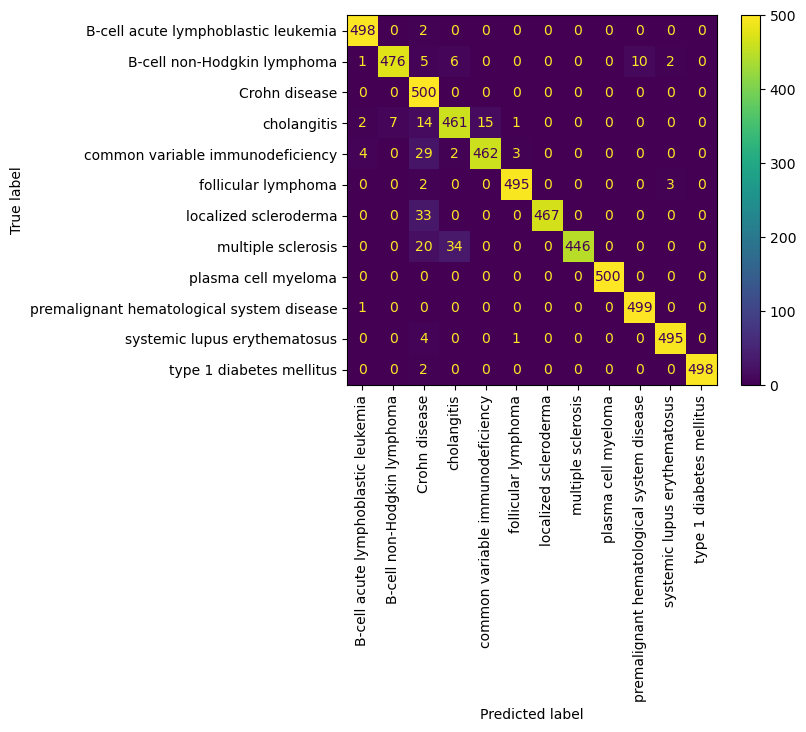

In [47]:
# Define the Random Forest pipeline
rf_pipe = Pipeline([('forest', RandomForestClassifier(random_state=42))])

# Hyperparameters for Random Forest to search
params = {
    'forest__n_estimators': [100,400],        
#    'forest__max_depth': [None, 10],          
    'forest__min_samples_split': [20],      
    'forest__criterion': ['gini']             
}

# Perform RandomizedSearchCV on rf_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(rf_pipe,
                          param_distributions=params, 
                          scoring='f1_weighted',
                          n_jobs=3,
                          refit='recall',
                          pre_dispatch="2*n_jobs",
                          n_iter=4,
                          cv=2,
                          random_state=42).fit(X_train_real10,y_train_real10)
end_time = time.time()

# How much time did it take
execution_time = end_time - start_time

# Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test, y_test)
report = classification_report(y_test, preds, output_dict=True)

# Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test, preds, labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels).plot()
plt.xticks(rotation=90)

# Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

# Save results in the dataframe
rf2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train_real10)]
                     }, index=['RandomForest classifier + cell bias'])

rf_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
rf2_df

## AdaBoost Classfier with real cells

/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters:  {'ada__n_estimators': 200, 'ada__estimator': DecisionTreeClassifier(max_depth=1)}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
AdaBoost classifier + cell bias,0.473,0.423,0.47,0.423,0.392,0.748,9829.0,281406


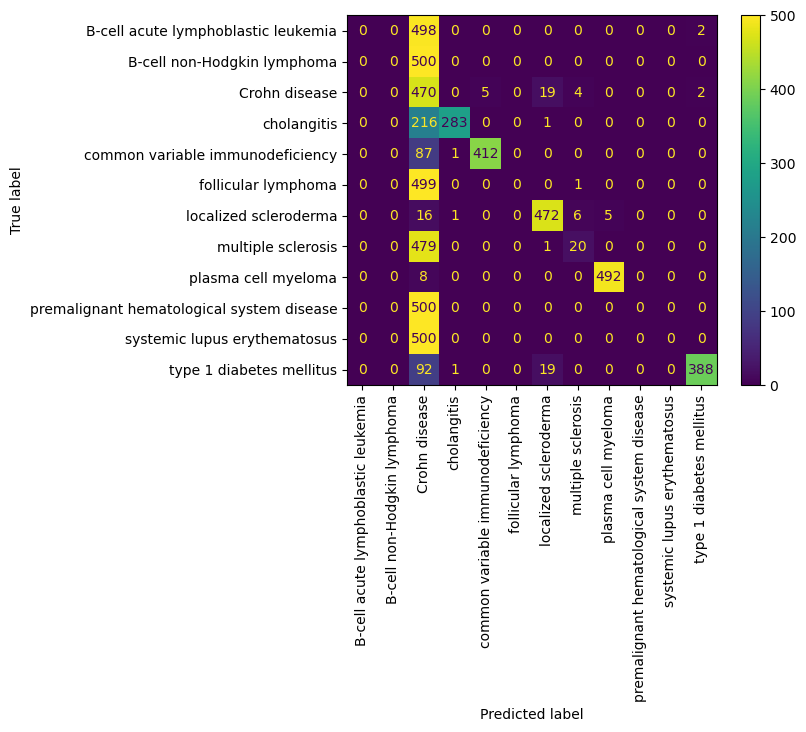

In [48]:
# Define the AdaBoost pipeline
ada_pipe = Pipeline([('ada', AdaBoostClassifier(random_state=42, algorithm='SAMME.R'))])

# Hyperparameters for AdaBoost to search
params = {
    'ada__n_estimators': [200],      
#    'ada__learning_rate': [0.1, 1],
    'ada__estimator': [DecisionTreeClassifier(max_depth=d) for d in [1]]
}

# Perform RandomizedSearchCV on ada_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(
    ada_pipe,
    param_distributions=params,
    scoring='f1_weighted',
    n_jobs=3,
    refit='recall',
    pre_dispatch="1*n_jobs",
    n_iter=1,
    cv=3,
    random_state=42
).fit(X_train_real10,y_train_real10)
end_time = time.time()

# How much time did it take
execution_time = end_time - start_time

# Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test, y_test)
report = classification_report(y_test, preds, output_dict=True)

# Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test, preds, labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels).plot()
plt.xticks(rotation=90)

# Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

# Save results in the dataframe
ada2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train_real10)]
                      }, index=['AdaBoost classifier + cell bias'])

ada_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
ada2_df

## Gradient Boosting Classfier with real cells

Best Parameters:  {'gb__n_estimators': 100, 'gb__max_depth': 3}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
GradientBoosting classifier + cell bias,1.0,0.87,0.906,0.87,0.873,0.989,734.7,3055


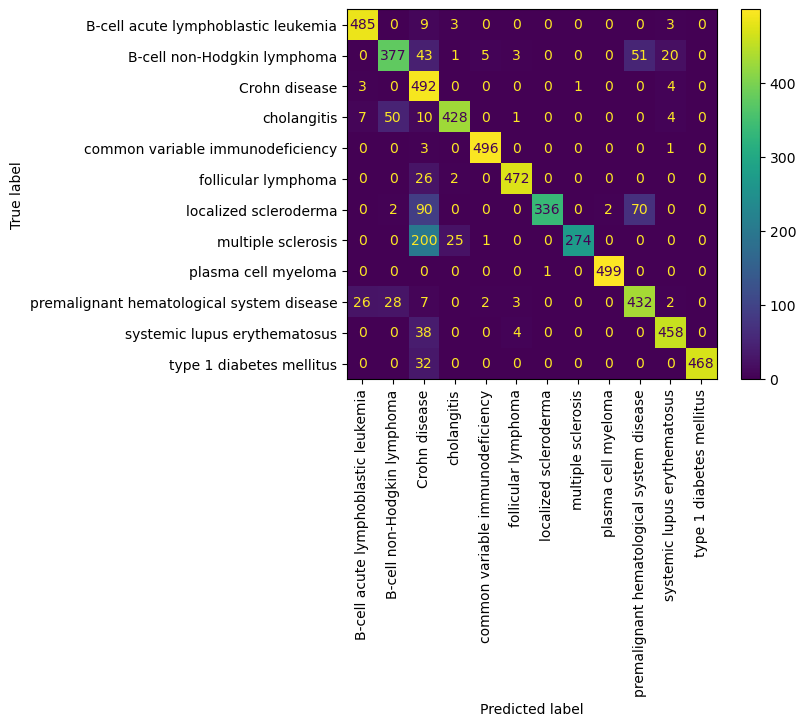

In [66]:
# Define the Gradient Boosting pipeline
gb_pipe = Pipeline([('gb', GradientBoostingClassifier(random_state=42))])

# Hyperparameters for Gradient Boosting to search
params = {
    'gb__n_estimators': [100],      # Similar to AdaBoost: number of trees
#    'gb__learning_rate': [0.1, 1.0],     # Step size shrinkage
    'gb__max_depth': [1, 3]           # Maximum depth of individual trees
}

# Perform RandomizedSearchCV on gb_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(
    gb_pipe,
    param_distributions=params,
    scoring='f1_weighted',
    n_jobs=-1,
    refit='recall',
    pre_dispatch="2*n_jobs",
    n_iter=2,
    cv=2,
    random_state=42
).fit(X_train_real10,y_train_real10)
end_time = time.time()

# How much time did it take
execution_time = end_time - start_time

# Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test, y_test)
report = classification_report(y_test, preds, output_dict=True)

# Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test, preds, labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels).plot()
plt.xticks(rotation=90)

# Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

# Save results in the dataframe
gb2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                          'Test accuracy':[round(acc_test,3)],
                          'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                          'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                          'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                          'Weighted ROC AUC':[round(roc_auc_value,3)],
                          'Training time[s]':[round(execution_time,1)],
                          'Trained on N cells':[len(y_train_real10)]
                     }, index=['GradientBoosting classifier + cell bias'])

gb_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
gb2_df

## Linear SVC with real cells

Best Parameters:  {'svc__estimator__C': 10}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
Linear SVC + cell bias,1.0,0.997,0.997,0.997,0.997,1.0,106.3,66102


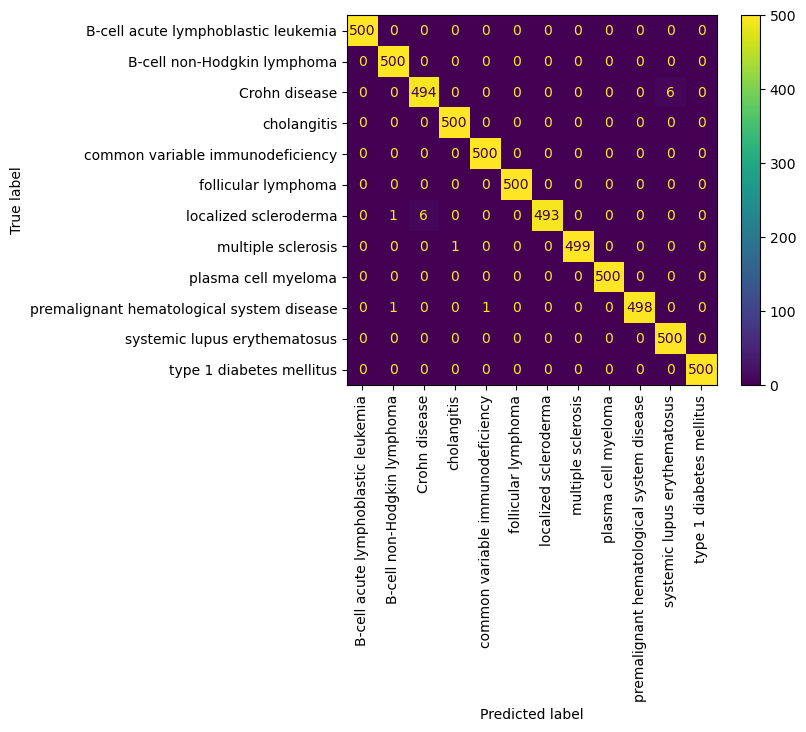

In [147]:
# Suppress ConvergenceWarning
warnings.filterwarnings("ignore")

# Define the pipeline with LinearSVC and calibration
svc_pipe = Pipeline([
    ('svc', CalibratedClassifierCV(
        estimator=LinearSVC(max_iter=2000, class_weight='balanced'),
        method='sigmoid'
    ))
])

# Hyperparameters to search
svc_params = {
    'svc__estimator__C': [10]  # Regularization strength
}
#Perform RandomizedSearchCV on svc pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(svc_pipe,
                          param_distributions=svc_params,
                          scoring='f1_weighted',
                          n_jobs=3,
                          refit='recall',
                          pre_dispatch="2*n_jobs",
                          n_iter=1,
                          cv=2).fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
svc2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
                        'Test accuracy':[round(acc_test,3)],
                        'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
                        'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
                        'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
                        'Weighted ROC AUC':[round(roc_auc_value,3)],
                        'Training time[s]':[round(execution_time,1)],
                        'Trained on N cells':[len(y_train_real10)]
             },index=['Linear SVC + cell bias'])
svc2_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params) 
svc2_df

# Summary:

In [233]:
#Had to manually write down some of the data because calculations were run over mutliple days and state was not saved so it cannot be recalled
svc1_df = pd.DataFrame({'Training accuracy':[0.384],
                          'Test accuracy':[0.309],
                          'Weighted avg precision':[0.454],
                          'Weighted avg recall':[0.309],
                          'Weighted avg F-1 score':[0.264],
                          'Weighted ROC AUC':[0.805],
                          'Training time[s]':[16350.1],
                          'Trained on N cells':[14471]
                       },index=['Linear SVC - cell bias'])				
rf1_df = pd.DataFrame({'Training accuracy':[0.998],
                          'Test accuracy':[0.756],
                          'Weighted avg precision':[0.892],
                          'Weighted avg recall':[0.756],
                          'Weighted avg F-1 score':[0.766],
                          'Weighted ROC AUC':[0.978],
                          'Training time[s]':[578.1],
                          'Trained on N cells':[36177]
                       },index=['Random forest classifier - cell bias'])
ada1_df = pd.DataFrame({'Training accuracy':[0.271],
                          'Test accuracy':[0.546],
                          'Weighted avg precision':[0.633],
                          'Weighted avg recall':[0.546],
                          'Weighted avg F-1 score':[0.539],
                          'Weighted ROC AUC':[0.758],
                          'Training time[s]':[1190.1],
                          'Trained on N cells':[36177]
                       },index=['AdaBoost classifier - cell bias'])
gb1_df = pd.DataFrame({'Training accuracy':[0.67],
                          'Test accuracy':[0.638],
                          'Weighted avg precision':[0.64],
                          'Weighted avg recall':[0.638],
                          'Weighted avg F-1 score':[0.618],
                          'Weighted ROC AUC':[0.905],
                          'Training time[s]':[12125.4],
                          'Trained on N cells':[14471]
                       },index=['GradientBoosting classifier - cell bias'])
dtree2_df = pd.DataFrame({'Training accuracy':[0.922],
                          'Test accuracy':[0.784],
                          'Weighted avg precision':[0.826],
                          'Weighted avg recall':[0.784],
                          'Weighted avg F-1 score':[0.776],
                          'Weighted ROC AUC':[0.965],
                          'Training time[s]':[3696.9],
                          'Trained on N cells':[281406]
                       },index=['DecisionTree classifier + cell bias'])
rf2_df = pd.DataFrame({'Training accuracy':[1.0],
                          'Test accuracy':[0.966],
                          'Weighted avg precision':[0.969],
                          'Weighted avg recall':[0.966],
                          'Weighted avg F-1 score':[0.967],
                          'Weighted ROC AUC':[0.999],
                          'Training time[s]':[3330.1],
                          'Trained on N cells':[281406]
                       },index=['RandomForest classifier + cell bias'])
ada2_df = pd.DataFrame({'Training accuracy':[0.473],
                          'Test accuracy':[0.423],
                          'Weighted avg precision':[0.47],
                          'Weighted avg recall':[0.423],
                          'Weighted avg F-1 score':[0.392],
                          'Weighted ROC AUC':[0.748],
                          'Training time[s]':[9829.0],
                          'Trained on N cells':[281406]
                       },index=['AdaBoost classifier + cell bias'])
knn2_df = pd.DataFrame({'Training accuracy':[0.783],
                          'Test accuracy':[0.607],
                          'Weighted avg precision':[0.819],
                          'Weighted avg recall':[0.607],
                          'Weighted avg F-1 score':[0.609],
                          'Weighted ROC AUC':[0.826],
                          'Training time[s]':[8174.3],
                          'Trained on N cells':[281406]
                       },index=['KNN classifier + cell bias'])

In [234]:
summary1 = pd.concat([dummy1_df,logreg1_df,rf1_df, gb1_df,ada1_df,dtree1_df,svc1_df, knn1_df,dummy2_df,logreg2_df,svc2_df,rf2_df,gb2_df,dtree2_df,knn2_df,ada2_df])
summary1

,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s],Trained on N cells
Dummy classifier - cell bias,0.151,0.083,0.007,0.083,0.013,0.500,0.0,71831
LogReg classifier - cell bias,0.350,0.809,0.855,0.809,0.786,0.959,696.8,71831
Random forest classifier - cell bias,0.998,0.756,0.892,0.756,0.766,0.978,578.1,36177
GradientBoosting classifier - cell bias,0.670,0.638,0.640,0.638,0.618,0.905,12125.4,14471
AdaBoost classifier - cell bias,0.271,0.546,0.633,0.546,0.539,0.758,1190.1,36177
DecisionTree classifier - cell bias,0.971,0.468,0.443,0.468,0.447,0.714,254.0,36623
Linear SVC - cell bias,0.384,0.309,0.454,0.309,0.264,0.805,16350.1,14471
KNN classifier - cell bias,0.278,0.291,0.336,0.291,0.252,0.656,285.9,71831
Dummy classifier + cell bias,0.250,0.083,0.007,0.083,0.013,0.500,0.0,66102
LogReg classifier + cell bias,1.000,0.999,0.999,0.999,0.999,1.000,79.1,66102


# Conclusions:  
1. From the perspective of models without cell bias, Logistic Regression achieved the highest weighted average recall & F-1 score.
2. From the perspective of cell type-biased models, Logistic Regression and Linear SVC showed the best recall and F-1 score.
3. The best models (Logistic Regression and Random Forest classifiers) for the dataset without cell type bias struggled with localized scleroderma and type 1 diabetes. These diseases had the fewest donors, and it is anticipated that prediction accuracy would improve with more patient data in the training set. 

# Next steps:
1. Only a very small number of cells were used in training due to resource limitations. More extensive training with a larger dataset would likely yield better results.
2. One of the caveats of this study is the variable number of cells used during training. It was found that some models scale poorly as the number of cells increases, particularly the GradientBoosting classifier and Linear SVC without cell type bias. Under unrestricted resources, these models should be compared on datasets of the same size.
3. The current model makes predictions per cell, whereas multiple cells are available per patient. A model that could aggregate multiple per-cell predictions—such as through majority voting—would likely provide better results.
4. The current model does not predict whether a patient is healthy. It will be critical to include healthy donors for each disease type in future studies.